### **Importing libraries**

In [2]:
# setup the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn import tree
from tqdm import tqdm
from sklearn.tree import export_text
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from joblib import dump

### **Loading the dataset**

In [4]:
data_df = pd.read_csv('/content/drive/MyDrive/work_kesara/archive/Maternal Health Risk Data Set.csv')
data_df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


### **Data preprocessing**

In [5]:
print(data_df.shape)

(1014, 7)


In [6]:
print(data_df.dtypes)

Age              int64
SystolicBP       int64
DiastolicBP      int64
BS             float64
BodyTemp       float64
HeartRate        int64
RiskLevel       object
dtype: object


**Handling null values**

In [7]:
# checking are there any null values to handle the null values
data_df.isnull().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

**Handling duplicates values**

In [8]:
# checking for duplicate values
num_duplicates = data_df.duplicated().sum()
print(num_duplicates)

562


In [9]:
# removing those duplicates from the dataset

# adding true label for duplicates values
data_df.drop_duplicates(inplace=True)

# checking whether are there remaining duplicates, after the removing
print(data_df.duplicated().any())


False


In [10]:
# getting new shape of the dataset
print(data_df.shape)

(452, 7)


**Encoding categorical values into numerical values**

In [11]:
# getting unique labels from target variable
data_df['RiskLevel'].unique()

array(['high risk', 'low risk', 'mid risk'], dtype=object)

In [12]:
# applying numerical mapping for the label data

# defining the mapping
risk_level_mapping = {'low risk': 0,
                      'mid risk': 1,
                      'high risk': 2}

# applying mapping to the target column
data_df['RiskLevel'] = data_df['RiskLevel'].map(risk_level_mapping).astype(float)

print(data_df.head())

   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86        2.0
1   35         140           90  13.0      98.0         70        2.0
2   29          90           70   8.0     100.0         80        2.0
3   30         140           85   7.0      98.0         70        2.0
4   35         120           60   6.1      98.0         76        0.0


**Handling outliers**

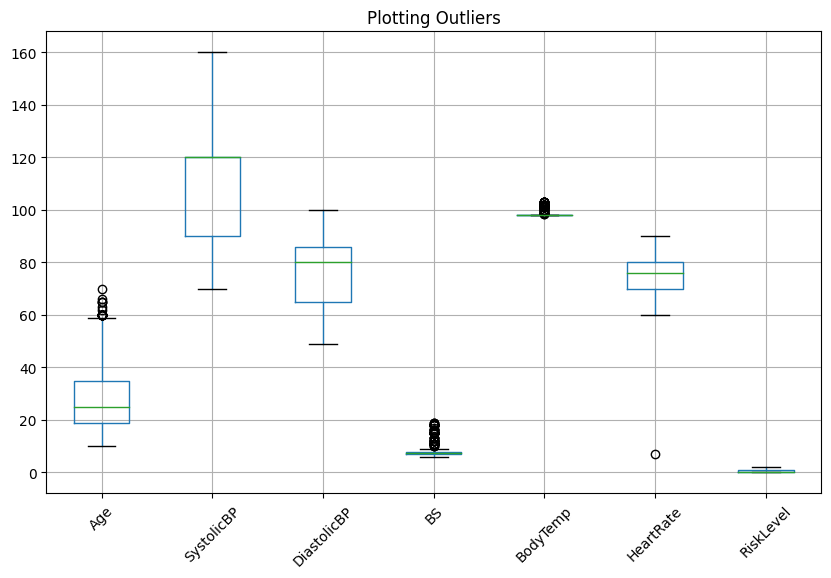

In [13]:
# checking for outliers to handling outliers
plt.figure(figsize=(10, 6))
data_df.boxplot()
plt.title('Plotting Outliers')
plt.xticks(rotation=45)
plt.show()

In [14]:
# checking data for the patient who have abnormal heart rate
heart_rate_below_20 = data_df[data_df['HeartRate'] < 20]
print(heart_rate_below_20)

     Age  SystolicBP  DiastolicBP   BS  BodyTemp  HeartRate  RiskLevel
499   16         120           75  7.9      98.0          7        0.0


In [15]:
# removing the outlier from heart rate column
data_df = data_df[data_df['HeartRate'] >= 20]
print(data_df.shape)

(451, 7)


**Plotting crrelation matrix**

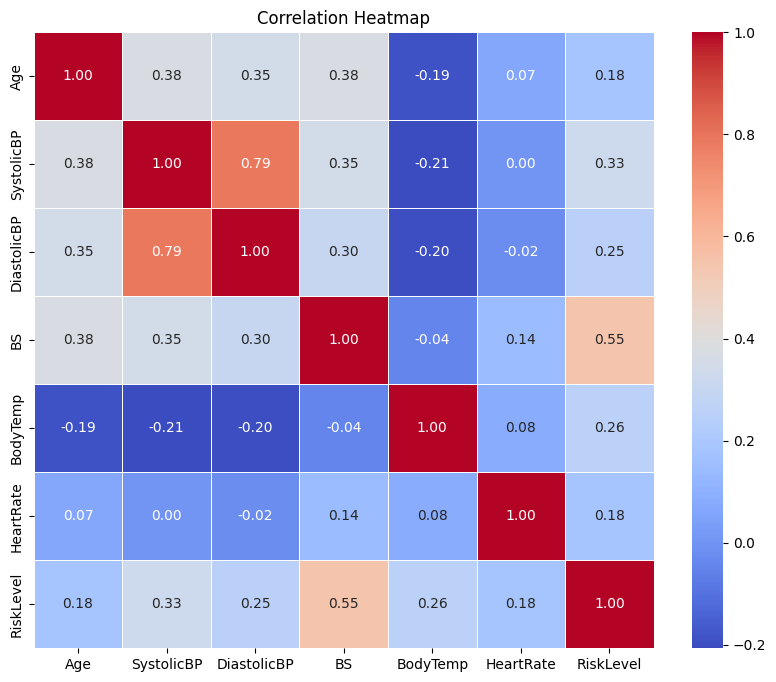

In [16]:
# checking correlations between other columns and the target column

# getting the correlation matrix
correlation_matrix = data_df.corr()

# plotting heatmap for visualize the correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


RiskLevel
0.0    233
2.0    112
1.0    106
Name: count, dtype: int64


<ipython-input-17-fa801833e833>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RiskLevel', data=data_df, palette='viridis')


<Axes: xlabel='RiskLevel', ylabel='count'>

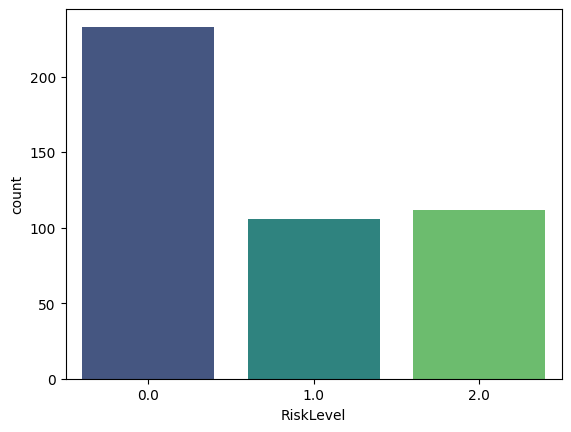

In [17]:
# getting value counts for each labels in the target column
print(data_df['RiskLevel'].value_counts())
sns.countplot(x='RiskLevel', data=data_df, palette='viridis')

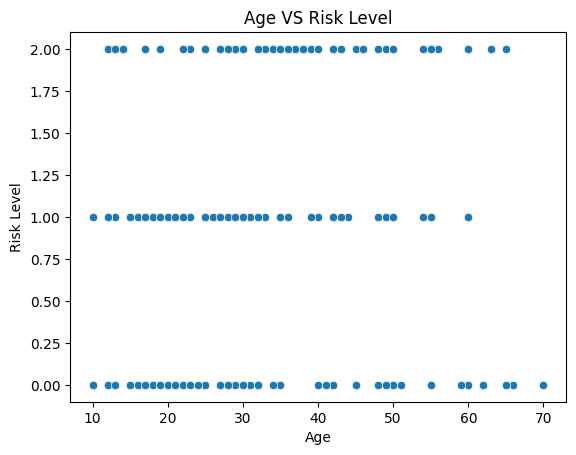

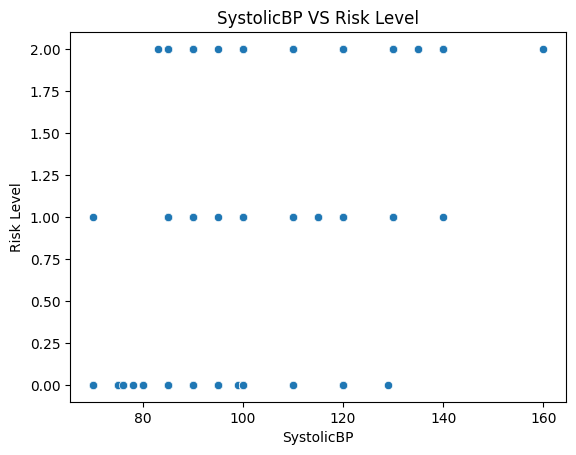

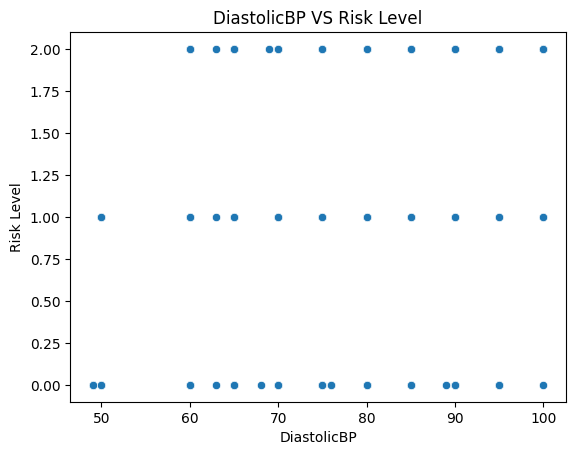

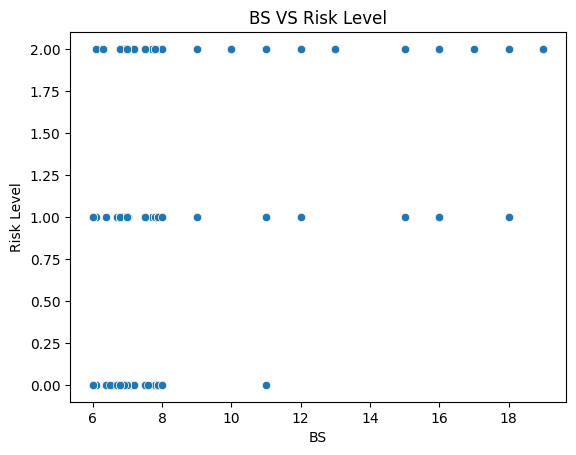

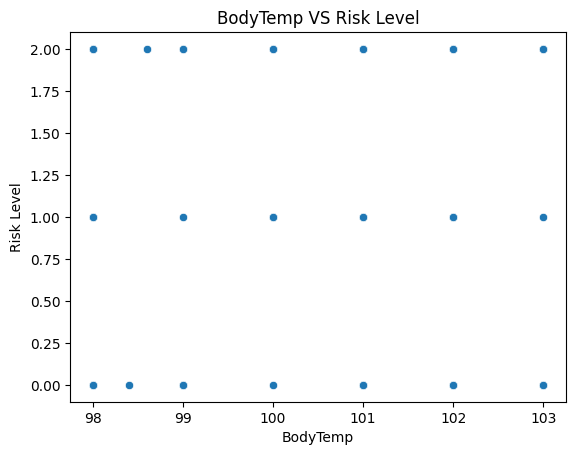

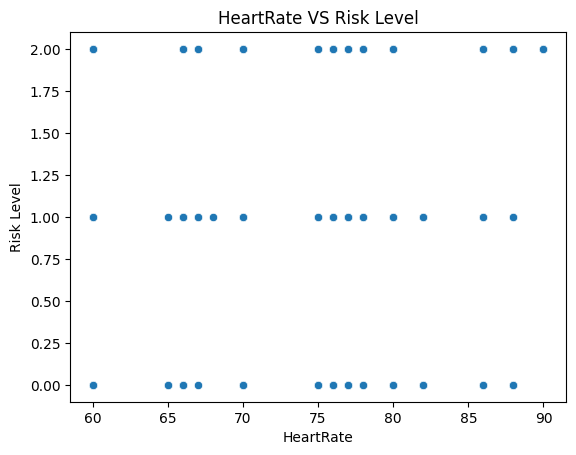

In [18]:
# plotting each featureagainst the target varaiable
for feature in data_df.columns:

  if feature != 'RiskLevel':
    sns.scatterplot(x=feature, y='RiskLevel', data=data_df)
    plt.title(f'{feature} VS Risk Level')
    plt.xlabel(feature)
    plt.ylabel('Risk Level')
    plt.show()

**Seperating feature data and target data**

In [19]:
Y = data_df['RiskLevel']
X = data_df.drop(columns=['RiskLevel'])

print(f'shape of the target variable {Y.shape}')
print(f'shape of the feature variable {X.shape}')

shape of the target variable (451,)
shape of the feature variable (451, 6)


**Splitting data into train and test data sets**

In [20]:
# getting train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

**Normalizing data feature data**

In [21]:
# defining scalaing function
StandardScaler = StandardScaler()

# applying scaling
X_train = StandardScaler.fit_transform(X_train)
X_test = StandardScaler.transform(X_test)

### **Applying SVM classifier with hyper parameter tunning**

In [22]:
# defining the hyper parameters
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']}

# creating the SVM classifier
svm = SVC(random_state=0)

# defining the GridSearchCV object
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)

# performing the grid search
grid_search.fit(X_train, Y_train)

# getting the best SVM model from best parameters
best_svm = grid_search.best_estimator_

In [23]:
# getting train and test accuracies
train_accuracy = best_svm.score(X_train, Y_train)
test_accuracy = best_svm.score(X_test, Y_test)

print(f'Train accuracy - {train_accuracy}')
print(f'Test accuracy - {test_accuracy}')

Train accuracy - 0.7611111111111111
Test accuracy - 0.7252747252747253


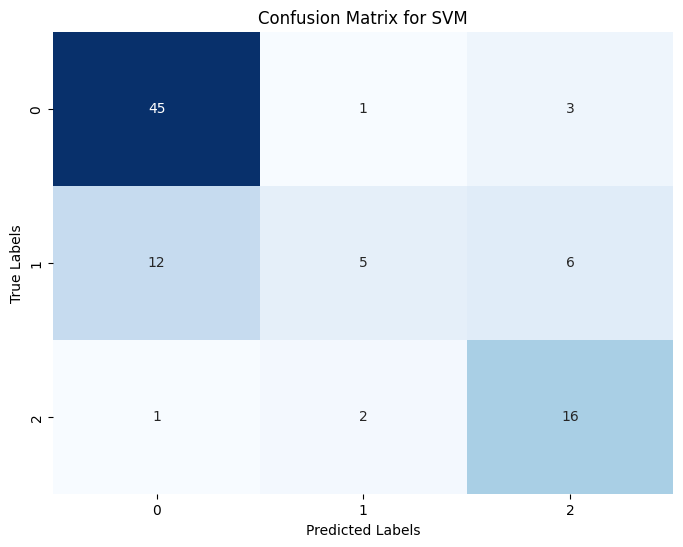

In [32]:
# getting predictions for test data
Y_predict = best_svm.predict(X_test)

# getting confusion matrix
conf_mat = confusion_matrix(Y_test, Y_predict)

# plotting the confuion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [25]:
# getting classification report
class_report = classification_report(Y_test, Y_predict)
print(class_report)

              precision    recall  f1-score   support

         0.0       0.78      0.92      0.84        49
         1.0       0.62      0.22      0.32        23
         2.0       0.64      0.84      0.73        19

    accuracy                           0.73        91
   macro avg       0.68      0.66      0.63        91
weighted avg       0.71      0.73      0.69        91



### **Classification using XGBoost model**

In [26]:
# defining the hyper parameters
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200, 300]
}

# creating the XGBoost classifier
xgb_model = xgb.XGBClassifier()

# defining the gridsearch object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5)

# performing the grid search
grid_search.fit(X_train, Y_train)

# getting the best xgb model
best_xgb_model = grid_search.best_estimator_

In [27]:
# getting train and test accuracies
train_accuracy = best_xgb_model.score(X_train, Y_train)
test_accuracy = best_xgb_model.score(X_test, Y_test)

print(f'Train accuracy - {train_accuracy}')
print(f'Test accuracy - {test_accuracy}')

Train accuracy - 0.8111111111111111
Test accuracy - 0.7472527472527473


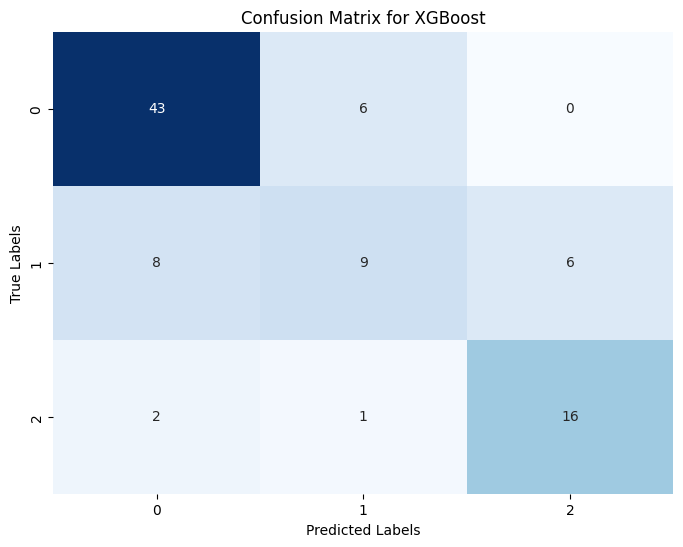

In [34]:
# getting predictions for test data
Y_predict = best_xgb_model.predict(X_test)

# getting confusion matrix
conf_mat = confusion_matrix(Y_test, Y_predict)

# plotting the confuion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [35]:
# getting classification report
class_report = classification_report(Y_test, Y_predict)
print(class_report)

              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84        49
         1.0       0.56      0.39      0.46        23
         2.0       0.73      0.84      0.78        19

    accuracy                           0.75        91
   macro avg       0.70      0.70      0.70        91
weighted avg       0.73      0.75      0.73        91



### **Applying desicion tree classifier**

In [38]:
# defining the hyper parameters
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Create the DecisionTreeClassifier
dt_classifier = tree.DecisionTreeClassifier(random_state=0)

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, verbose=2)

# Perform the grid search
grid_search.fit(X_train, Y_train)

# Get the best model
best_dt_model = grid_search.best_estimator_

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=   0.0s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, mi

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

[CV] END criterion=gini, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, min_

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=auto, mi

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=6, max_features=sqrt, min

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=7, max_features=auto, mi

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=8, max_features=sqrt, mi

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

[CV] END criterion=gini, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=9, max_features=auto, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=9, max_features=auto, min_sam

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=aut

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

[CV] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_dept

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

[CV] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_dep

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

[CV] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_dep

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

[CV] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=8, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=8

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

[CV] END criterion=entropy, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=entropy, max

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


In [39]:
# getting train and test accuracies
train_accuracy = best_dt_model.score(X_train, Y_train)
test_accuracy = best_dt_model.score(X_test, Y_test)

print(f'Train accuracy - {train_accuracy}')
print(f'Test accuracy - {test_accuracy}')

Train accuracy - 0.7333333333333333
Test accuracy - 0.7252747252747253


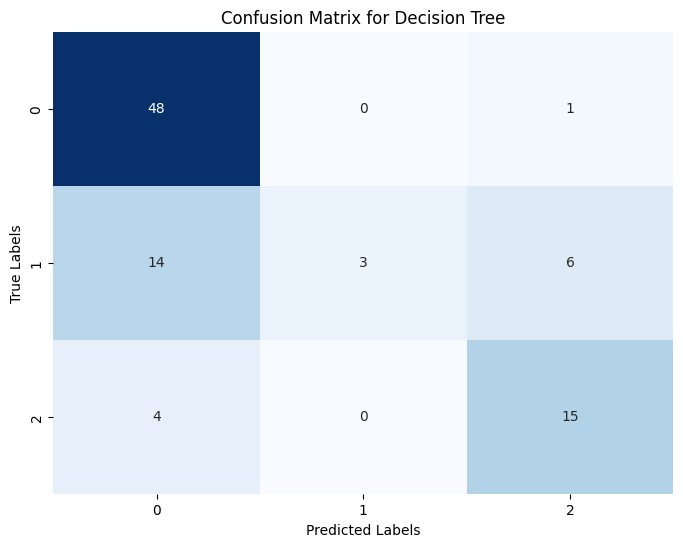

In [40]:
# getting predictions for test data
Y_predict = best_dt_model.predict(X_test)

# getting confusion matrix
conf_mat = confusion_matrix(Y_test, Y_predict)

# plotting the confuion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix for Decision Tree')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

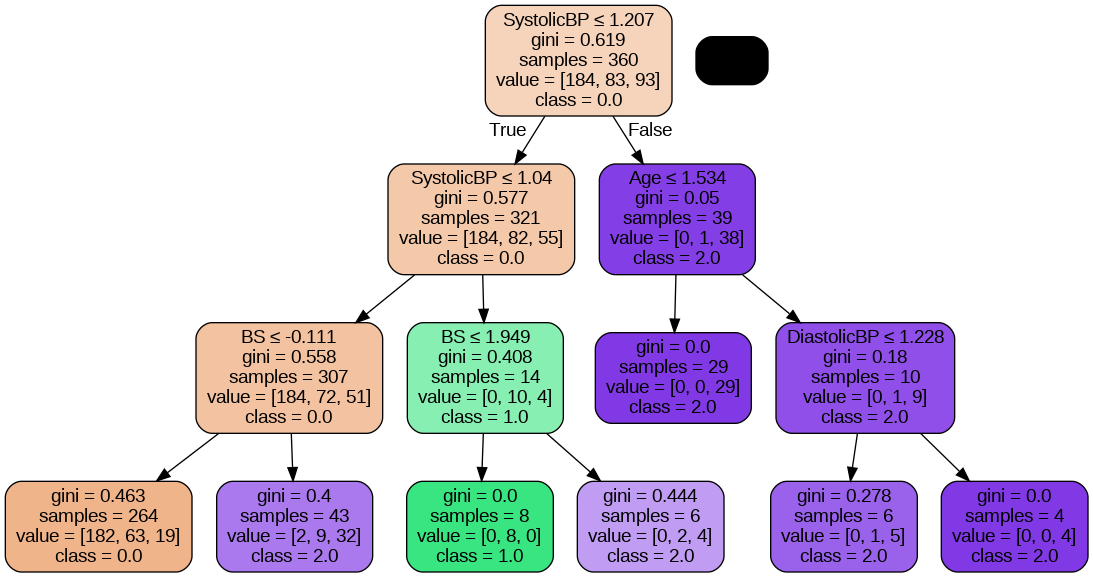

In [44]:
# visualizing the desicion tree
dot_data = StringIO()
features = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']

export_graphviz(
   best_dt_model,
   out_file=dot_data,
   filled=True,
   rounded=True,
   special_characters=True,
   feature_names = features,
   class_names = ['0.0', '1.0', '2.0']
)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('diabetes.png')
Image(graph.create_png())

### **Applying random forest classifier**

In [46]:
# Define the hyper parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create the Random Forest classifier
random_forest = RandomForestClassifier(random_state=0)

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5)

# Perform the grid search
grid_search.fit(X_train, Y_train)

# Get the best model
best_random_forest = grid_search.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

In [47]:
# getting train and test accuracies
train_accuracy = best_random_forest.score(X_train, Y_train)
test_accuracy = best_random_forest.score(X_test, Y_test)

print(f'Train accuracy - {train_accuracy}')
print(f'Test accuracy - {test_accuracy}')

Train accuracy - 0.7694444444444445
Test accuracy - 0.7362637362637363


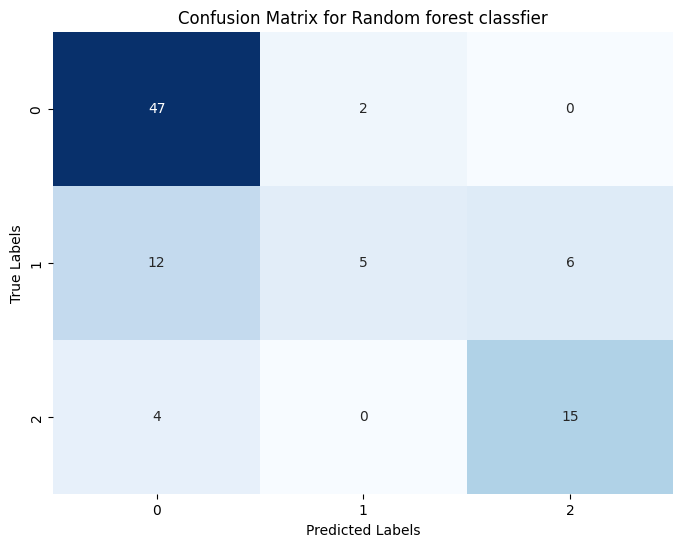

In [48]:
# getting predictions for test data
Y_predict = best_random_forest.predict(X_test)

# getting confusion matrix
conf_mat = confusion_matrix(Y_test, Y_predict)

# plotting the confuion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix for Random forest classfier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [50]:
# getting classification report
class_report = classification_report(Y_test, Y_predict)
print(class_report)

              precision    recall  f1-score   support

         0.0       0.75      0.96      0.84        49
         1.0       0.71      0.22      0.33        23
         2.0       0.71      0.79      0.75        19

    accuracy                           0.74        91
   macro avg       0.72      0.66      0.64        91
weighted avg       0.73      0.74      0.69        91



### **Apply logistic regression**

In [59]:
# Defining the hyper parameters
param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Create the Logistic Regression classifier
logistic_regression = LogisticRegression(max_iter=1000, random_state=0)

# Defining the GridSearchCV object
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=5)

# Perform the grid search
grid_search.fit(X_train, Y_train)

# Get the best model
best_logistic_regression = grid_search.best_estimator_

In [60]:
# getting train and test accuracies
train_accuracy = best_logistic_regression.score(X_train, Y_train)
test_accuracy = best_logistic_regression.score(X_test, Y_test)

print(f'Train accuracy - {train_accuracy}')
print(f'Test accuracy - {test_accuracy}')

Train accuracy - 0.6694444444444444
Test accuracy - 0.6813186813186813


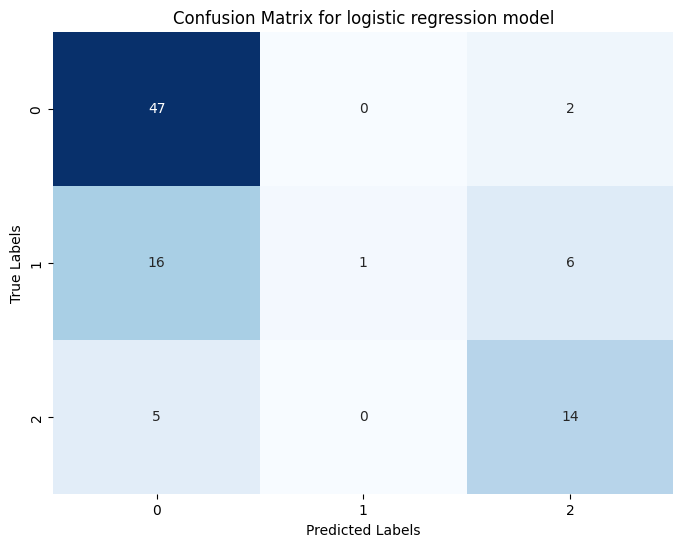

In [61]:
# getting predictions for test data
Y_predict = best_logistic_regression.predict(X_test)

# getting confusion matrix
conf_mat = confusion_matrix(Y_test, Y_predict)

# plotting the confuion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix for logistic regression model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [62]:
# getting classification report
class_report = classification_report(Y_test, Y_predict)
print(class_report)

              precision    recall  f1-score   support

         0.0       0.69      0.96      0.80        49
         1.0       1.00      0.04      0.08        23
         2.0       0.64      0.74      0.68        19

    accuracy                           0.68        91
   macro avg       0.78      0.58      0.52        91
weighted avg       0.76      0.68      0.60        91



In [67]:
# Saving the models
dump(best_svm, '/content/drive/MyDrive/work_kesara/SVM_model.joblib')
dump(best_xgb_model, '/content/drive/MyDrive/work_kesara/xgb_model.joblib')
dump(best_dt_model, '/content/drive/MyDrive/work_kesara/Decision_tree.joblib')
dump(best_random_forest, '/content/drive/MyDrive/work_kesara/random_forest.joblib')
dump(best_logistic_regression, '/content/drive/MyDrive/work_kesara/logistic_regression.joblib')

['/content/drive/MyDrive/work_kesara/logistic_regression.joblib']